In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.simplefilter(action= "ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 176)
pd.set_option("display.max_rows", 20)
pd.set_option("display.float_format", lambda x: "%.3f" %x)

In [2]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# Görev 1: Keşifçi Veri Analizi (EDA)

## Adım 1: Genel resmi inceleyiniz.

In [3]:
def check_df(dataframe, head = 5):
    print("\n********** Shape **********")
    print(dataframe.shape)
    print("\n********** Types **********")
    print(dataframe.dtypes)
    print("\n********** Head **********") 
    print(dataframe.head(head))
    print("\n********** Tail **********")
    print(dataframe.tail(head))
    print("\n********** NA **********")
    print(dataframe.isnull().sum())
    print("\n********** Quantiles **********")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)


********** Shape **********
(768, 9)

********** Types **********
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

********** Head **********
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0   

Bir kişinin glikoz değeri, kan basıncı, insülün değeri vs. 0 olamaz. Eksik değerimiz yok. Çünkü eksik değerlere 0 değeri atanmış olabilir.

## Adım 2: Numerik ve Kategorik değişkenleri yakalayınız.

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
cat_cols

['Outcome']

In [8]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

## Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

In [9]:
# Kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("####################################")

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe)
        plt.show()

In [10]:
cat_summary(df, "Outcome")

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
####################################


In [11]:
#Numerik değişkenlerin analizi
def num_summary(dataframe, numerical_col, plot = False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins = 20)
        plt.xlabel(numerical_col)
        plt.ylabel(numerical_col)
        plt.show()

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


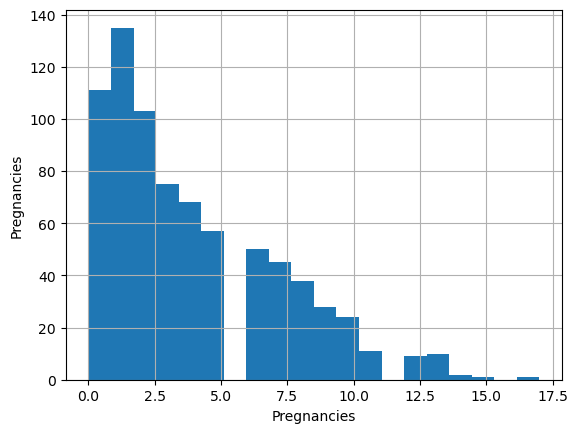

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


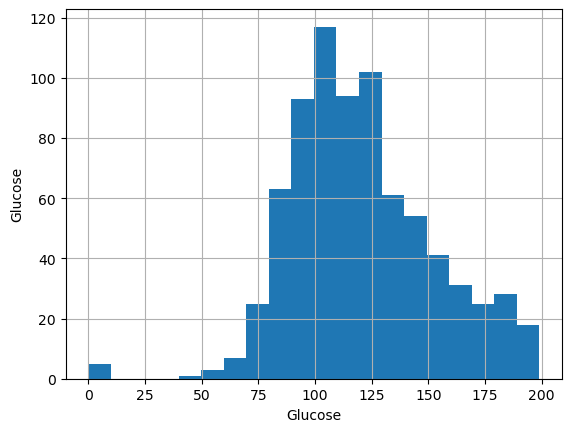

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


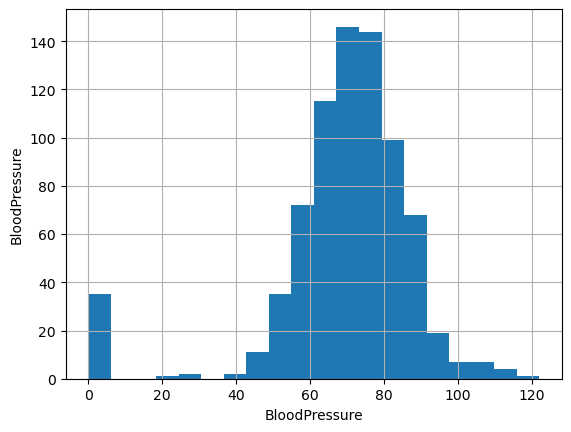

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


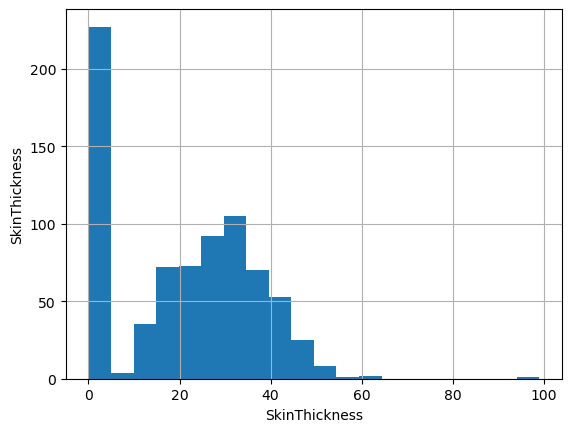

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


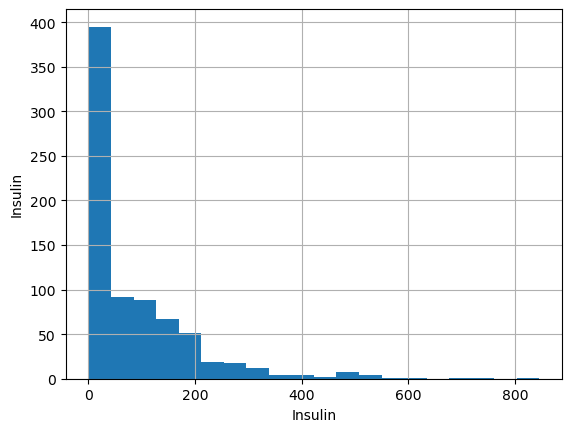

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


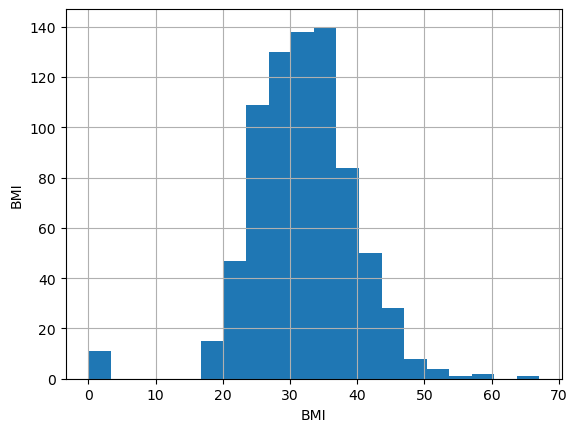

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


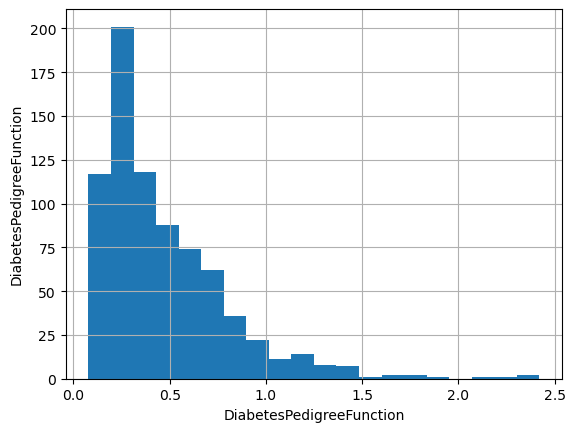

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


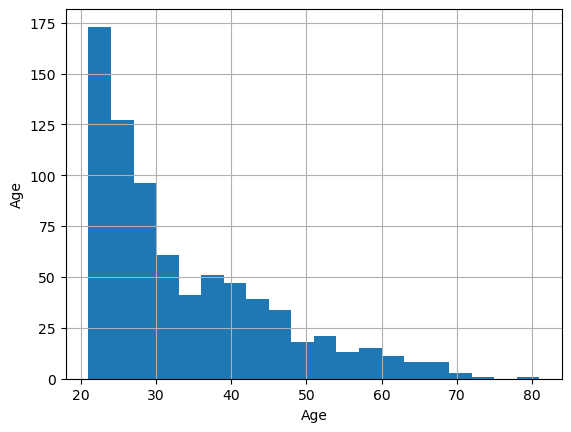

In [12]:
for col in num_cols:
    num_summary(df, col, plot = True)

In [13]:
#Numerik değişkenlerin target'a göre analizi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end = "\n\n\n")

In [14]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




In [15]:
# Korelasyon
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


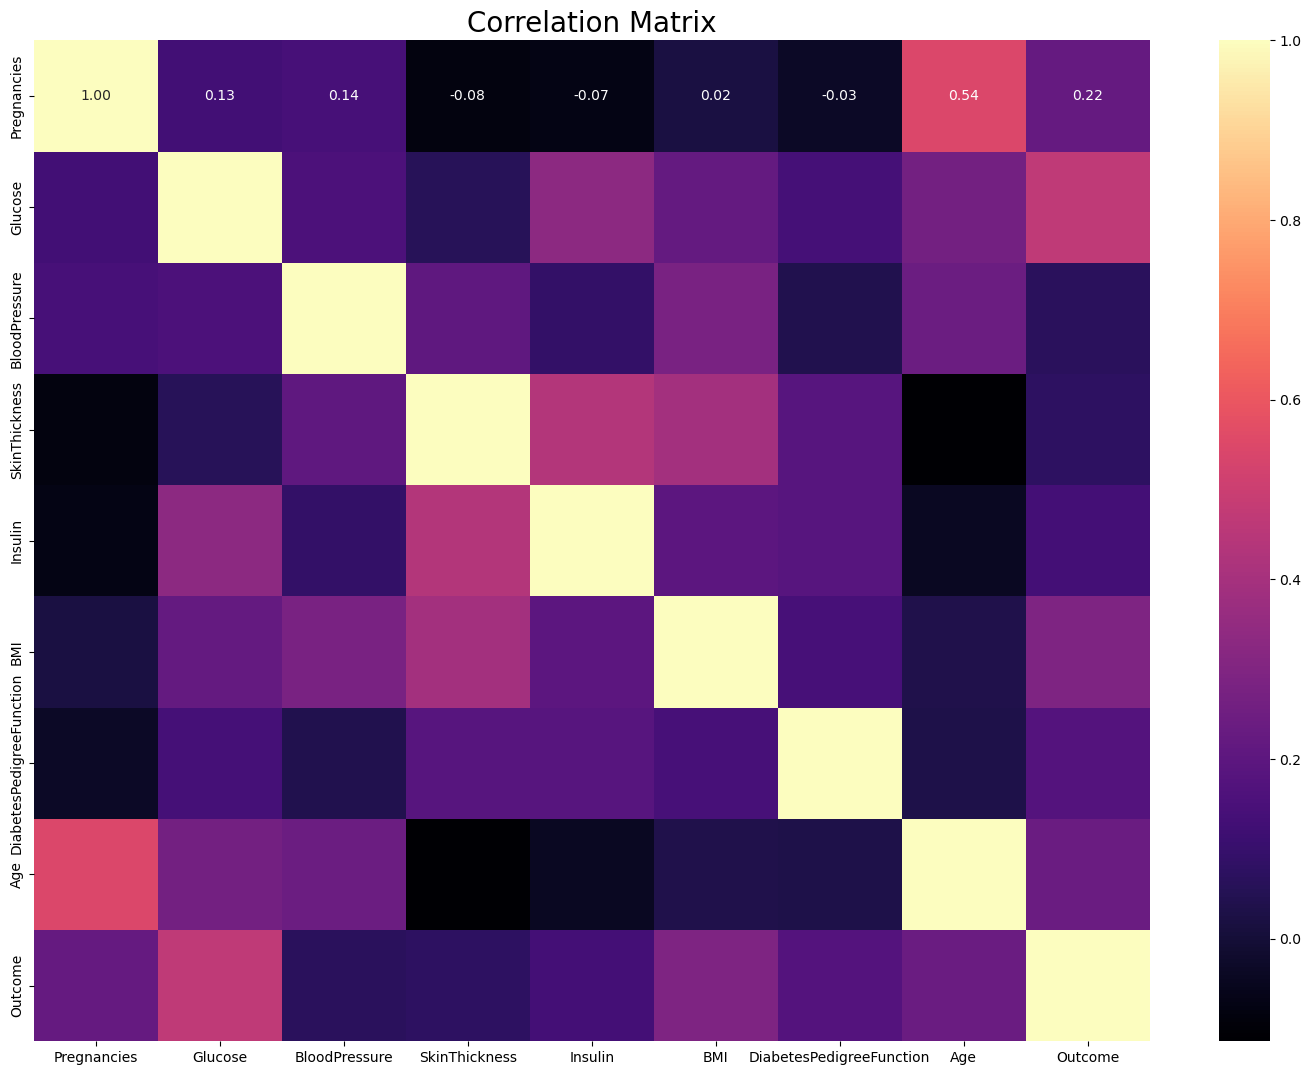

In [16]:
# Bunu bir de grafiğe dökelim.
f, ax = plt.subplots(figsize = [18, 13])
sns.heatmap(df.corr(), annot= True, fmt= ".2f", ax= ax, cmap= "magma")
ax.set_title("Correlation Matrix", fontsize= 20)
plt.show()

### BASE MODEL KURULUMU

In [17]:
y = df["Outcome"]
X = df.drop("Outcome", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [18]:
rf_model = RandomForestClassifier(random_state= 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [19]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


In [20]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

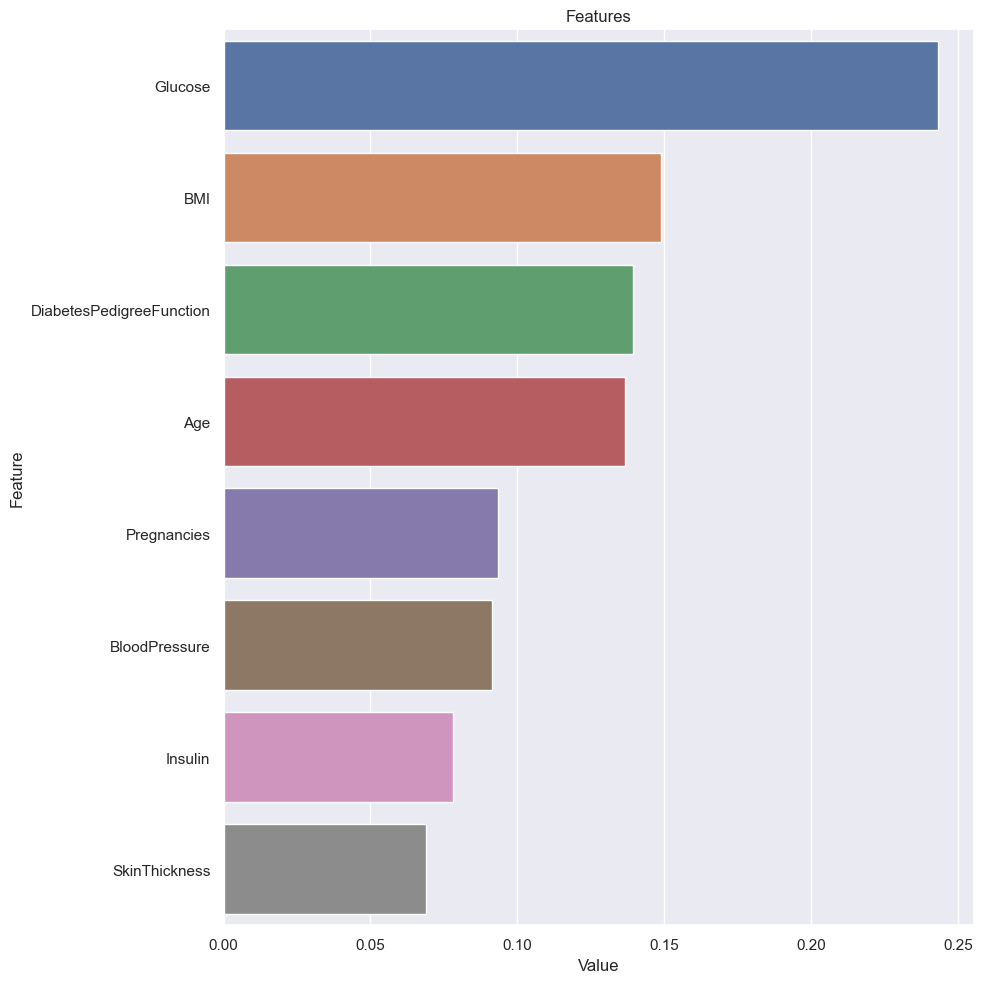

In [21]:
plot_importance(rf_model, X)

# Görev 2: FEATURE ENGNERRING

## Adım 1: Eksik değer analizi

Normalde check_df() ile analiz yaptığımızda verisetimizde boş değerler yoktı. Ama bir insanın kanındaki glikoz değeri, insülin veya BMI değeri 0 olamayacağı için bu gibi sütunlarda 0 olan değerlere NaN atayalım.

In [22]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [23]:
# Şimdi 0 değerlerini NaN ile değiştirelim.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [24]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [25]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [26]:
na_columns = missing_values_table(df, na_name = True)
na_columns

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [27]:
# Eksik değerlerin bağımlı değişken ile ilişkisinin incelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


In [28]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [29]:
# Eksik değerlerimizi tespit ettik, şimdi doldurma zamanı.
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

In [30]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Adım 2: Aykırı değer analizi

In [31]:
def outlier_tresholds(dataframe, col_name, q1 = 0.05, q3 = 0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)

    interquantile_range = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    return low_limit, up_limit
    
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis = None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_tresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [32]:
# Aykırı değerler var ise onları baskılayalım
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [33]:
for col in df.columns:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


## Adım 3: Özellik çıkarımı

In [34]:
# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [35]:
# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası overweight ve 30 üstü obez
df["NEW_BMI"] = pd.cut(x = df["BMI"], bins = [0, 18.5, 24.9, 29.9, 100], labels = ["Underweight", "Healty", "Overweight", "Obese"])

In [36]:
# Glukoz 140 aşağısı normal, 140 ile 200 arası prediyabet, 200 üstü diyabet
df["NEW_GLUCOSE"] = pd.cut(x = df["Glucose"], bins = [0, 140, 200, 300], labels = ["Normal", "Prediabetes", "Diabetes"])

In [37]:
# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"

df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"

df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"

df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"


In [38]:
# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"

df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"

df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"

df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


In [39]:
# İnsülin değeri ile kategorik değişken türetelim
def set_insulin(dataframe, col_name = "Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Anormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis = 1)

In [40]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]

In [41]:
# Oluşturduğumuz tüm column adlarını sıkıntı olmaması için büyük harflere çevirelim
df.columns = [col.upper() for col in df.columns]

In [42]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healty,Prediabetes,obesemature,highmature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Anormal,23016.000,0.000


In [43]:
df.shape

(768, 17)

In [44]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3


## Adım 4: Encoding

### Label encoding

In [45]:
def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe

In [46]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_AGE_CAT', 'NEW_INSULIN_SCORE']

In [47]:
for col in binary_cols:
    df = label_encoder(df, col)

In [48]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,Prediabetes,obesesenior,highsenior,1,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,Normal,obesemature,normalmature,1,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healty,Prediabetes,obesemature,highmature,1,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,Normal,obesemature,normalmature,1,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,Normal,obesemature,highmature,0,23016.000,0.000


### One hot encoding

In [49]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [50]:
def one_hot_encoder(dataframe, categorical_cols, drop_first = False):
    dataframe = pd.get_dummies(dataframe, columns= categorical_cols, drop_first= drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first = True)

In [51]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healty,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,1,10625.000,85.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,22875.000,1464.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,1,8366.000,89.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [52]:
df.shape

(768, 27)

## Adım 5: Standartlaştırma

In [53]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [54]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healty,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,True,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,0,1,-0.503,-0.858,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,0,1,0.317,2.129,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,0,1,-0.654,-0.849,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,False,False,False,True,False,False,False,False,False,False,False,True,False,False


In [55]:
df.shape

(768, 27)

## Adım 6: MODELLEME

In [56]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [57]:
rf_model = RandomForestClassifier(random_state= 46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [58]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 3)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


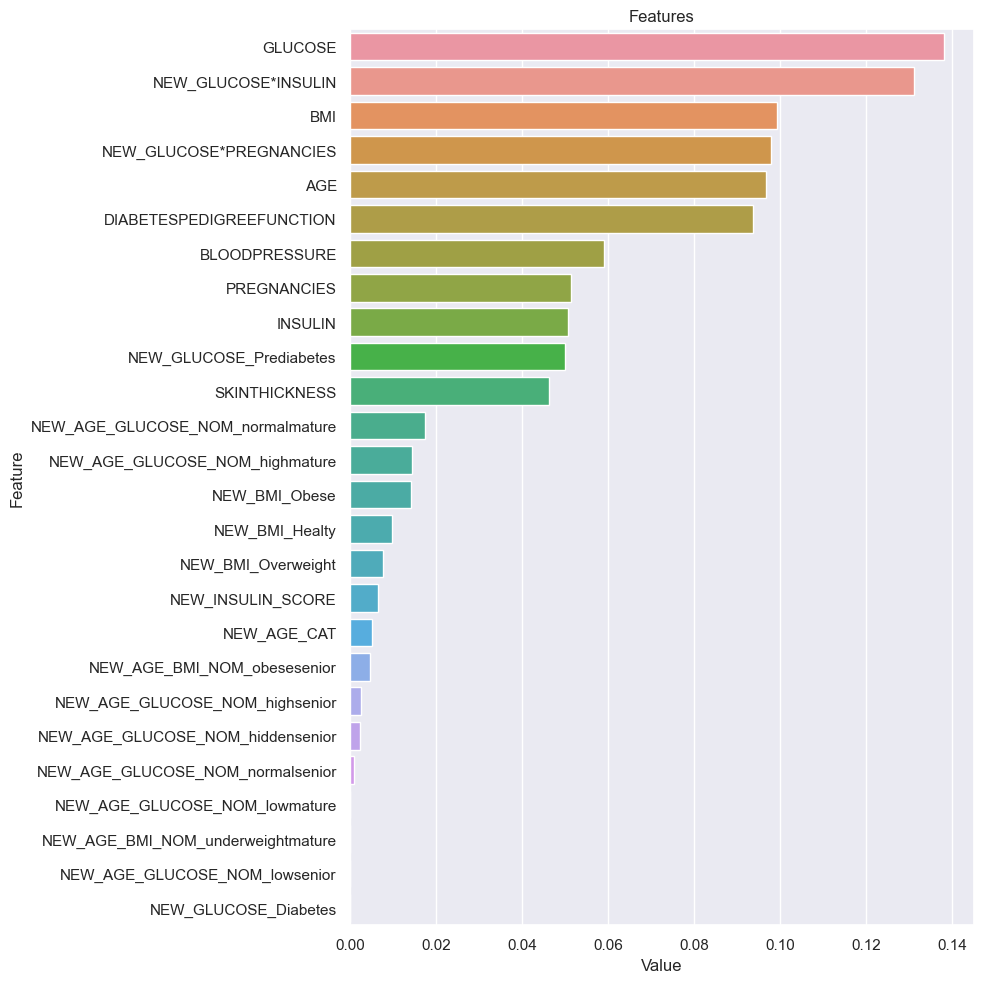

In [59]:
plot_importance(rf_model, X)